In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tensorflow import keras
from utils.layer import DecompositionLayer
from utils.detect_roll_over import calculate_load_margin_v2
from utils.miscellaneous import create_seq_dataset_multiple_input_single_output, get_dataset
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

In [2]:
dataset = get_dataset(data_root_path='data')
feature_name_list = dataset.columns.tolist()[4:7]

  0%|          | 0/22 [00:00<?, ?it/s]

In [3]:
result_df = calculate_load_margin_v2(dataset)
dataset = pd.concat([dataset, result_df], axis=1)

  0%|          | 0/22 [00:00<?, ?it/s]

In [4]:
dataset

,Time(sec),file_idx,safe_state,dataset_type,Boom_Angle(deg),Swing_Angle(deg),Load(Ton),Roll_Angle(deg),Yaw_Angle(deg),Pitch_Angle(deg),...,Actual_Load_Right_1(N),Actual_Load_Right_2(N),Actual_Load_Right_3(N),Actual_Load_Right_4(N),Actual_Load_Right_5(N),mean_left_load,mean_right_load,mean_front_load,mean_rear_load,roll_over_det
0,0.000000,0.0,0.0,0.0,70.000000,0.000000e+00,40.0,0.000000e+00,0.000000,0.000000,...,1.500000e-17,1.500000e-17,1.500000e-17,1.500000e-17,1.500000e-17,-1.685333e-10,2.000000,1.000000,1.000000,1.0
1,0.100253,0.0,0.0,0.0,69.991015,7.420000e-27,40.0,1.680000e-06,-0.002929,0.000100,...,1.697395e+02,1.924783e+02,2.156748e+02,2.391432e+02,2.626973e+02,9.899341e-01,1.010066,0.836947,1.163053,0.0
2,0.200253,0.0,0.0,0.0,69.964391,5.570000e-28,40.0,6.280000e-06,-0.008808,-0.000031,...,2.070414e+02,1.998797e+02,1.927559e+02,1.856756e+02,1.786442e+02,9.905653e-01,1.009435,1.055547,0.944453,0.0
3,0.300253,0.0,0.0,0.0,69.920487,2.420000e-28,40.0,1.960000e-06,-0.011963,0.000050,...,1.689708e+02,1.803375e+02,1.918453e+02,2.034703e+02,2.151890e+02,9.922432e-01,1.007757,0.909078,1.090922,0.0
4,0.400253,0.0,0.0,0.0,69.859665,-2.500000e-28,40.0,-1.670000e-07,-0.009673,0.000073,...,1.590204e+02,1.753470e+02,1.919920e+02,2.088829e+02,2.259475e+02,9.945030e-01,1.005497,0.868802,1.131198,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9086,34.560253,21.0,1.0,0.0,40.168937,9.000000e+01,90.0,-2.903044e+01,0.205110,0.426372,...,-1.796157e-01,-1.784018e-01,-1.771879e-01,-1.759739e-01,-1.747600e-01,2.000799e+00,-0.000799,0.992459,1.007541,1.0
9087,34.660253,21.0,1.0,0.0,40.101532,9.000000e+01,90.0,-3.111229e+01,0.277094,0.454006,...,-1.819294e-01,-1.806997e-01,-1.794700e-01,-1.782403e-01,-1.770106e-01,2.000803e+00,-0.000803,0.992664,1.007336,1.0
9088,34.760253,21.0,1.0,0.0,40.050904,9.000000e+01,90.0,-3.325960e+01,0.346184,0.481887,...,-1.827294e-01,-1.814940e-01,-1.802586e-01,-1.790232e-01,-1.777878e-01,2.000798e+00,-0.000798,0.989738,1.010262,1.0
9089,34.860253,21.0,1.0,0.0,40.017413,9.000000e+01,90.0,-3.546086e+01,0.398743,0.509776,...,-1.818445e-01,-1.806146e-01,-1.793847e-01,-1.781548e-01,-1.769249e-01,2.000781e+00,-0.000781,0.982289,1.017711,1.0


In [5]:
seq_len = 30
pred_distance = 0

val_dataset = dataset[feature_name_list+['roll_over_det']].to_numpy()

val_feature, val_target = create_seq_dataset_multiple_input_single_output(data=val_dataset,
                                                                          seq_len=seq_len,
                                                                          pred_distance=pred_distance,
                                                                          target_idx_pos=val_dataset.shape[1]-1)
val_target = np.squeeze(val_target)
print(val_feature.shape, val_target.shape)

print((val_feature.itemsize*val_feature.size)/(1024**2))
print((val_target.itemsize*val_target.size)/(1024**2))

creating sequence dataset...:   0%|          | 0/9091 [00:00<?, ?it/s]

(9062, 30, 3) (9062,)
6.222381591796875
0.0691375732421875


In [6]:
model = keras.models.load_model(f'models/model_{pred_distance}.keras', custom_objects={'DecompositionLayer': DecompositionLayer})

In [7]:
val_pred = model.predict(val_feature, verbose=1)

284/284 [==============================] - 15s 31ms/step


In [8]:
val_target_string = []

for val in val_target:
    if val == 1:
        val_target_string.append('Unsafe')
    else:
        val_target_string.append('Safe')

result_df = pd.concat([pd.DataFrame(val_pred, columns=['prediction']),
                       pd.DataFrame(val_target_string, columns=['target'])], axis=1)

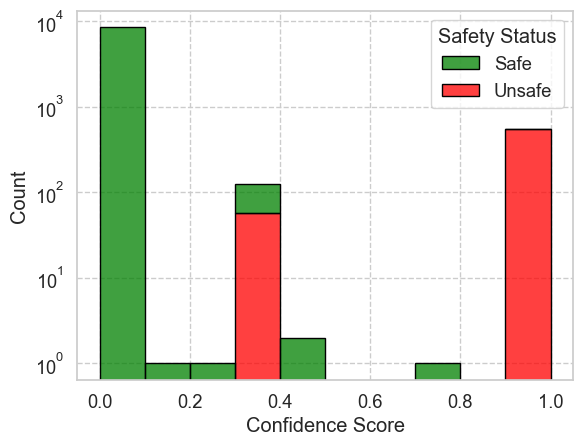

In [9]:
sns.set_theme(font_scale=1.2)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

custom_color = {'Unsafe': 'red', 'Safe': 'green'}

ax = sns.histplot(data=result_df, x='prediction', hue='target', bins=10, multiple='stack', edgecolor='black', palette=custom_color)

plt.xlabel('Confidence Score')
plt.yscale('log')

ax.legend_.set_title('Safety Status')

Best Threshold: 0.720
Best F1 Score: 0.9503


Text(0, 0.5, 'Score')

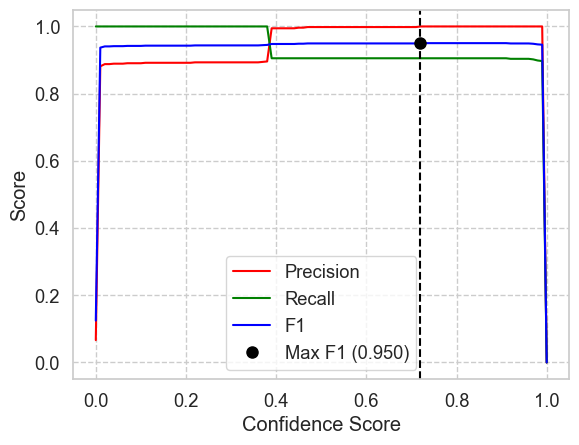

In [10]:
thr_val_arr = np.arange(0.0, 1.01, 0.01)

precision_arr = []
recall_arr = []
f1_arr = []

for thr_val in thr_val_arr:
    val_pred_binary = np.where(val_pred > thr_val, 1, 0)
    precision = precision_score(val_target, val_pred_binary, zero_division=0)
    recall = recall_score(val_target, val_pred_binary, zero_division=0)
    f1 = f1_score(val_target, val_pred_binary, zero_division=0)

    precision_arr.append(precision)
    recall_arr.append(recall)
    f1_arr.append(f1)

precision_arr = np.array(precision_arr)
recall_arr = np.array(recall_arr)
f1_arr = np.array(f1_arr)

sns.set_theme(font_scale=1.2)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.lineplot(x=thr_val_arr, y=precision_arr, color='red', label='Precision')
sns.lineplot(x=thr_val_arr, y=recall_arr, color='green', label='Recall')
sns.lineplot(x=thr_val_arr, y=f1_arr, color='blue', label='F1')

# 1. 최대 F1 점수의 인덱스 찾기
best_f1_index = np.argmax(f1_arr)

# 2. 해당 인덱스의 Threshold 값과 F1 점수 찾기
best_threshold = thr_val_arr[best_f1_index]
best_f1_score = f1_arr[best_f1_index]

# 3. 콘솔에 최적 값 출력
print(f"Best Threshold: {best_threshold:.3f}")
print(f"Best F1 Score: {best_f1_score:.4f}")

plt.axvline(x=best_threshold, color='black', linestyle='--')

# 5. F1 곡선 위에 최대 지점을 원(marker)으로 표시
plt.plot(best_threshold, best_f1_score, 'o', color='black', markersize=8,
         markeredgecolor='black', label=f'Max F1 ({best_f1_score:.3f})')

plt.legend()

plt.xlabel('Confidence Score')
plt.ylabel('Score')

([<matplotlib.axis.YTick at 0x240b9ab8790>,
 [Text(0, 0.5, 'Safe(0)'), Text(0, 1.5, 'Unsafe(1)')])

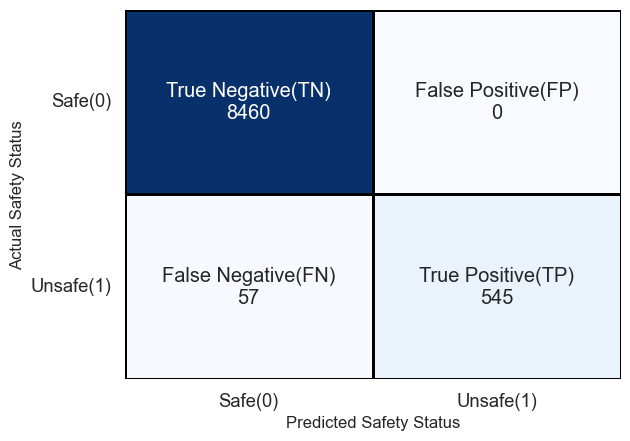

In [11]:
val_pred_binary = np.where(val_pred > best_threshold, 1, 0)

cm = confusion_matrix(val_target, val_pred_binary)

labels = np.array([[f'True Negative(TN)\n{cm[0, 0]}', f'False Positive(FP)\n{cm[0, 1]}'],
                   [f'False Negative(FN)\n{cm[1, 0]}', f'True Positive(TP)\n{cm[1, 1]}']])

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, linecolor='black', linewidths=1)

plt.ylabel('Actual Safety Status', fontsize=12)
plt.xlabel('Predicted Safety Status', fontsize=12)

plt.xticks([0.5, 1.5], ['Safe(0)', 'Unsafe(1)'])
plt.yticks([0.5, 1.5], ['Safe(0)', 'Unsafe(1)'], rotation=0, va='center')

In [12]:
print(precision_score(val_target, val_pred_binary))
print(recall_score(val_target, val_pred_binary))
print(f1_score(val_target, val_pred_binary))

1.0
0.9053156146179402
0.9503051438535309


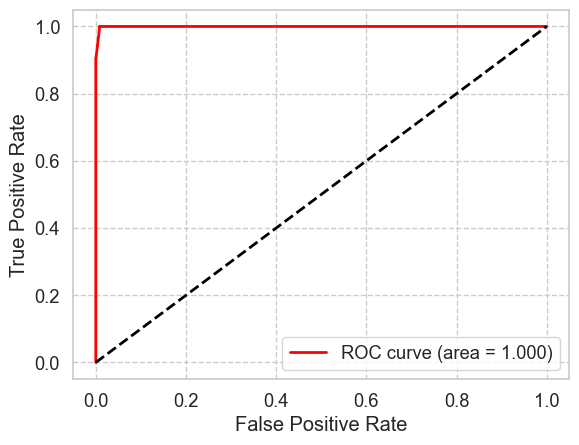

In [13]:
auc = roc_auc_score(y_true=val_target, y_score=val_pred)
fpr, tpr, thresholds = roc_curve(y_true=val_target, y_score=val_pred)

# 그래프 그리기
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--') # 50% 수준의 랜덤 모델
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)

In [26]:
false_negative_list = []

for i, target in enumerate(val_target):
    b = val_pred_binary[i]
    a = np.array([target, b]) == [1, 0]
    a = np.all(a)
    false_negative_list.append(a.astype(int))

sns.lineplot(val_target, linewidth=3, label='Target')
sns.lineplot(val_pred_binary, linestyle='--', label='Prediction')

plt.xlim(8500, 9000)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [40]:
result_list = []
count = 0

for i in range(len(val_target)):
    if i > 1:
        a = [val_target[i-1], val_target[i]]
        rising_edge = np.all(a==[0, 1])

        if rising_edge:
            count += 1
            result_list.append((i, count))

result_list

[(4727, 1),
 (5001, 2),
 (5292, 3),
 (5966, 4),
 (6276, 5),
 (6579, 6),
 (6889, 7),
 (7189, 8),
 (7559, 9),
 (7838, 10),
 (8126, 11),
 (8335, 12),
 (8671, 13),
 (8960, 14)]

In [41]:
def find_pulses_numpy(data):
    padded_data = np.concatenate(([0], data, [0]))
    diff = np.diff(padded_data)

    rising_indices = np.where(diff == 1)[0]
    falling_indices = np.where(diff == -1)[0]

    durations = falling_indices - rising_indices

    return list(zip(rising_indices, durations))

In [42]:
target_find = find_pulses_numpy(val_target)
pred_find = find_pulses_numpy(val_pred_binary)

In [43]:
time_diff_list = []
len_diff_list = []

for i in range(len(target_find)):
    time_diff = target_find[i][0] - pred_find[i][0]
    len_diff = target_find[i][1] - pred_find[i][1]

    time_diff_list.append(time_diff)
    len_diff_list.append(len_diff)

time_diff_list = np.array(time_diff_list)/10
len_diff_list = np.array(len_diff_list)/10

Text(0, 0.5, 'Difference of Duration(sec)')

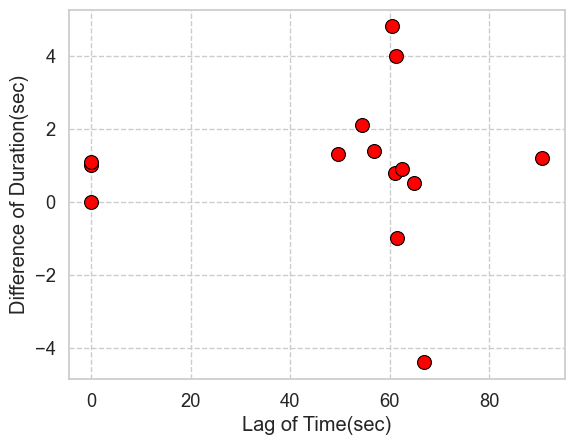

In [44]:
sns.scatterplot(x=time_diff_list, y=len_diff_list, color='red', edgecolor='black', s=100)

plt.xlabel('Lag of Time(sec)')
plt.ylabel('Difference of Duration(sec)')